In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import optuna

/home/user/upgrade/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv')


In [3]:
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [4]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (944, 10)

Columns in DataFrame:  ['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature', 'fail']

Data types of columns:
 footfall       int64
tempMode       int64
AQ             int64
USS            int64
CS             int64
VOC            int64
RP             int64
IP             int64
Temperature    int64
fail           int64
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    

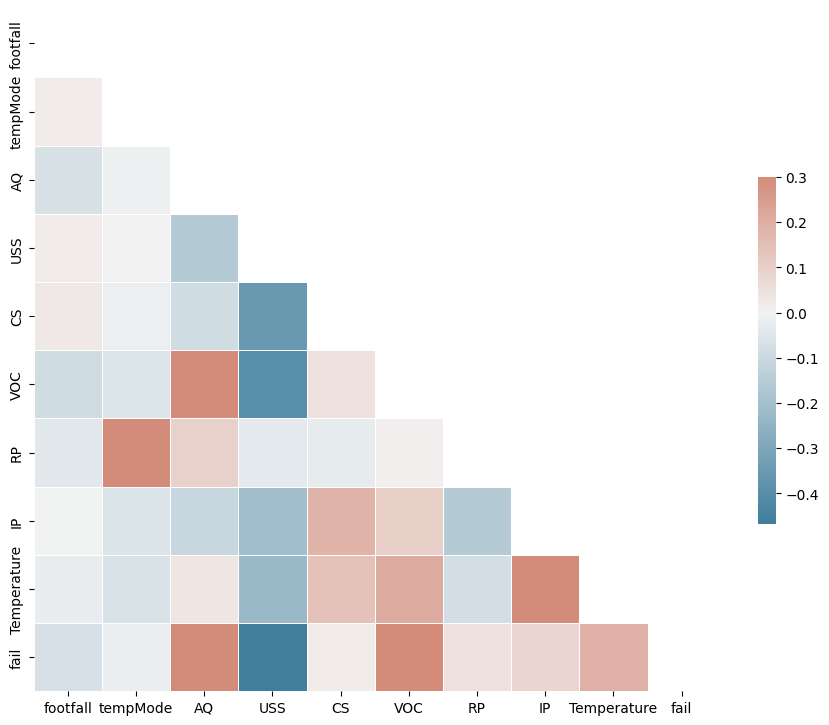

In [5]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [6]:
# Define the features and the target
X = df.drop('fail', axis=1)
y = df['fail']

In [7]:
def apply_models(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    min_samples = np.min(class_counts)
    max_samples = np.max(class_counts)
    imbalance_ratio = min_samples / max_samples
    
    if imbalance_ratio < 0.5:  # Adjusted threshold
        print(f"Class imbalance detected. Imbalance ratio: {imbalance_ratio:.2f}")
        if imbalance_ratio < 0.1:
            print("Severe imbalance. Applying SMOTE...")
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        else:
            print("Moderate imbalance. Consider adjusting class weights in models.")
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LogisticRegression': LogisticRegression(),
        'SVC': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'ExtraTrees': ExtraTreesClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoost': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
        'LDA': LinearDiscriminantAnalysis(),
        'Bagging': BaggingClassifier(),
        'KNeighbors': KNeighborsClassifier()
    }

    # Initialize a dictionary to hold the performance of each model
    model_performance = {}

    # Apply each model
    for model_name, model in models.items():
        print(f"\n\033[1mClassification with {model_name}:\033[0m\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the accuracy and f1 score
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the performance in the dictionary
        model_performance[model_name] = (accuracy, f1)

        # Print the accuracy score
        print("\033[1m**Accuracy**:\033[0m\n", accuracy)

        # Print the confusion matrix
        print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))

        # Print the classification report
        print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Sort the models based on f1 score and pick the top 3
    top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
    print("\n\033[1mTop 3 Models based on F1 Score:\033[0m\n", top_3_models)

    # Extract the model names and classifiers for the top 3 models
    top_3_model_names = [model[0] for model in top_3_models]
    top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

    # Create a Voting Classifier with the top 3 models
    print("\n\033[1mInitializing Voting Classifier with top 3 models...\033[0m\n")
    voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    print("\n\033[1m**Voting Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Create a Stacking Classifier with the top 3 models
    print("\n\033[1mInitializing Stacking Classifier with top 3 models...\033[0m\n")
    stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print("\n\033[1m**Stacking Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

In [8]:
apply_models(X, y)



Classification with LogisticRegression:
------------------------------
**Accuracy**:
 0.8677248677248677

**Confusion Matrix**:
 [[87 15]
 [10 77]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87       102
           1       0.84      0.89      0.86        87

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189


Classification with SVC:
------------------------------
**Accuracy**:
 0.873015873015873

**Confusion Matrix**:
 [[89 13]
 [11 76]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       102
           1       0.85      0.87      0.86        87

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189


Class

/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


**Accuracy**:
 0.8783068783068783

**Confusion Matrix**:
 [[88 14]
 [ 9 78]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       102
           1       0.85      0.90      0.87        87

    accuracy                           0.88       189
   macro avg       0.88      0.88      0.88       189
weighted avg       0.88      0.88      0.88       189


Classification with GradientBoost:
------------------------------
**Accuracy**:
 0.8783068783068783

**Confusion Matrix**:
 [[91 11]
 [12 75]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       102
           1       0.87      0.86      0.87        87

    accuracy                           0.88       189
   macro avg       0.88      0.88      0.88       189
weighted avg       0.88      0.88      0.88       189


Classification with XGBoost:
------------------------------
**Accu

/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:13:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/upgrade/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/home/user/upgrade/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subpro

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
**Accuracy**:
 0.8624338624338624

**Confusion Matrix**:
 [[89 13]
 [13 74]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       102
           1       0.85      0.85      0.85        87

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189


Classification with CatBoost:
------------------------------
**Accuracy**:
 0.8835978835978836

**Confusion Matrix**:
 [[90 12]
 [10 77]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89 

/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



**Voting Classifier Evaluation**:

**Accuracy**:
 0.8835978835978836

**Confusion Matrix**:
 [[88 14]
 [ 8 79]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       102
           1       0.85      0.91      0.88        87

    accuracy                           0.88       189
   macro avg       0.88      0.89      0.88       189
weighted avg       0.89      0.88      0.88       189


Initializing Stacking Classifier with top 3 models...



/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent


**Stacking Classifier Evaluation**:

**Accuracy**:
 0.873015873015873

**Confusion Matrix**:
 [[88 14]
 [10 77]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       102
           1       0.85      0.89      0.87        87

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189



/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
    }
    
    model = CatBoostClassifier(**params, random_state=42, verbose=False)
    
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-07-15 17:14:18,014] A new study created in memory with name: no-name-433548b6-fb60-4e42-a042-ecf998da4b37
[I 2024-07-15 17:14:20,998] Trial 0 finished with value: 0.9112582781456954 and parameters: {'iterations': 581, 'depth': 5, 'learning_rate': 0.055820069344956334, 'l2_leaf_reg': 1.0848542405967451e-08, 'border_count': 206, 'min_child_samples': 18, 'random_strength': 0.9242605531313135}. Best is trial 0 with value: 0.9112582781456954.
[I 2024-07-15 17:14:34,208] Trial 1 finished with value: 0.9139072847682119 and parameters: {'iterations': 710, 'depth': 10, 'learning_rate': 0.003154774172232904, 'l2_leaf_reg': 0.005296838711501912, 'border_count': 176, 'min_child_samples': 33, 'random_strength': 1.0709934781277866}. Best is trial 1 with value: 0.9139072847682119.
[I 2024-07-15 17:14:37,142] Trial 2 finished with value: 0.9112582781456954 and parameters: {'iterations': 523, 'depth': 6, 'learning_rate': 0.0020126363834525427, 'l2_leaf_reg': 9.75522283404911e-05, 'border_count'

Best trial:
  Value:  0.9192052980132452
  Params: 
    iterations: 339
    depth: 9
    learning_rate: 0.005818176882283606
    l2_leaf_reg: 2.7743273510435286e-07
    border_count: 68
    min_child_samples: 31
    random_strength: 4.051778802492884e-06


In [12]:
best_params = study.best_params
best_model = CatBoostClassifier(**best_params, random_state=42, verbose=False)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       102
           1       0.85      0.87      0.86        87

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189


Confusion Matrix:


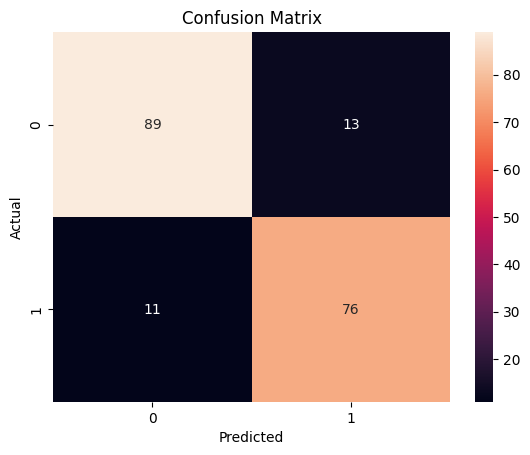

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

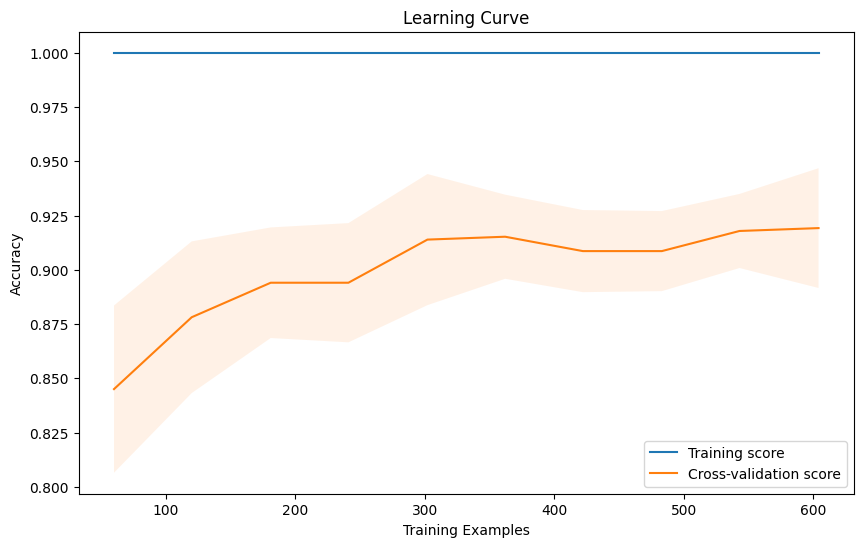

In [14]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

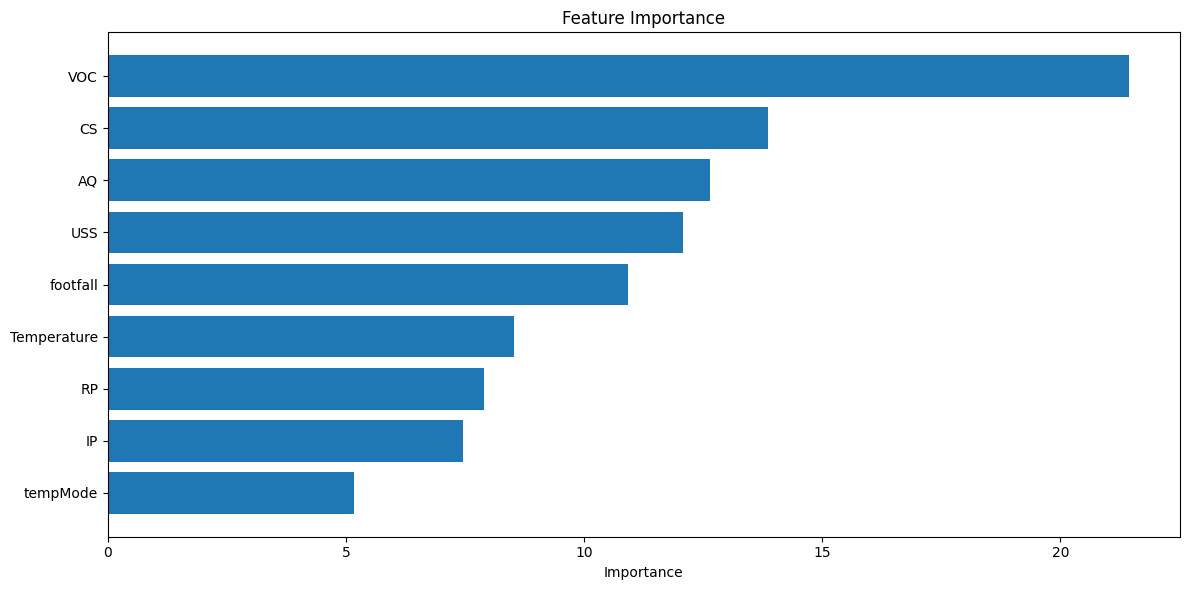

In [15]:
feature_importance = best_model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()